# 分类

给定2个概率分布p,q，计算2个概率分布的交叉熵

$H(X) =  - \sum {p(x_i)} ln(q(x_i))~~(i = 1,2, \ldots ,n)$

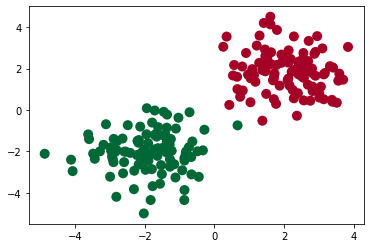

In [14]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

n_data = torch.ones(100,2)
x0 = torch.normal(2*n_data,1)
y0 = torch.zeros(100)
x1 = torch.normal(-2*n_data,1)
y1 = torch.ones(100)
x = torch.cat((x0,x1),0).type(torch.FloatTensor)
# 标签需要为Longtensor形式
y = torch.cat((y0,y1),).type(torch.LongTensor)

x,y = Variable(x),Variable(y)
plt.scatter(x.data.numpy()[:,0],x.data.numpy()[:,1],c=y.data.numpy(),s=100,lw=0,cmap='RdYlGn')
plt.show()

Net(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=2, bias=True)
)


/home/zelin/mytorch/torch/lib64/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


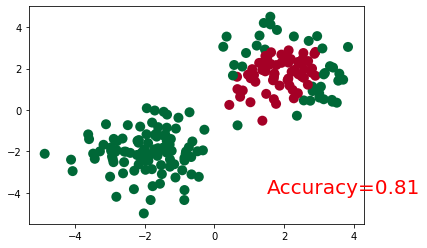

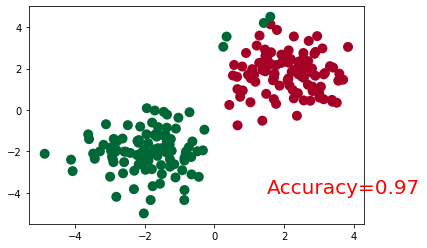

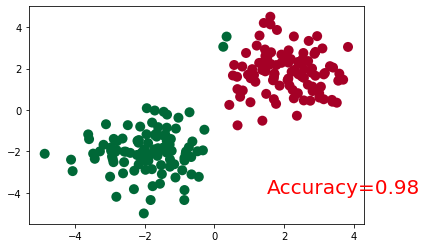

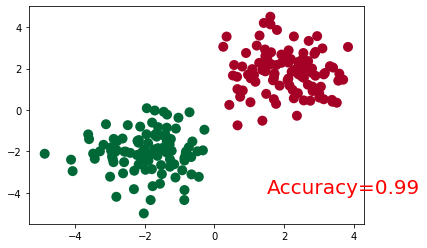

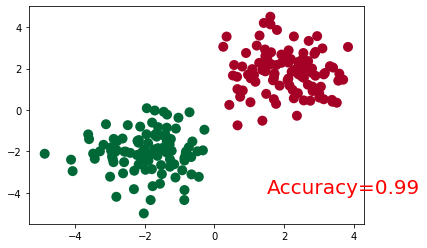

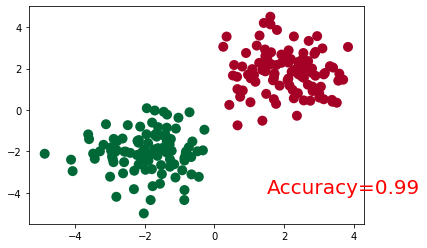

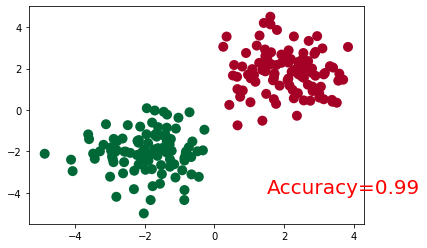

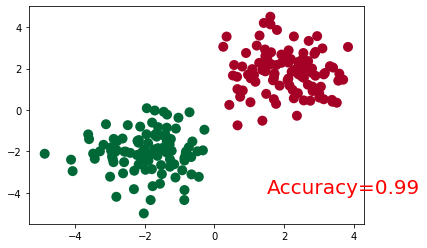

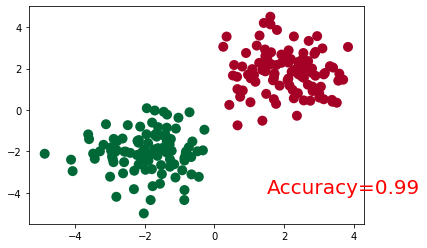

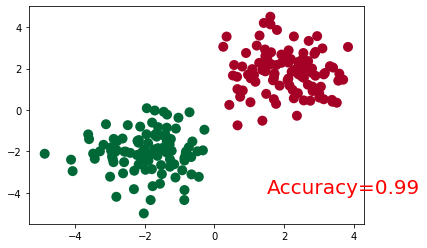

In [15]:
class Net(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(Net,self).__init__()
        self.hidden = torch.nn.Linear(n_feature,n_hidden)
        self.predict = torch.nn.Linear(n_hidden,n_output)
        
    def forward(self,x):
        x = F.relu(self.hidden(x))
        '''
        虽然视频里输出层没加激活函数为了不限制输出值y的范围，但不加激活函数时有时候拟合的曲线效果很差（会有部分横着一条线）
        我觉得大概是因为不加激活函数时反向传播的时候输出层权值的梯度容易变成0，输出层及之前层的参数就无法更新，从而学不到东西，加了sigmoid激活函数能非常有效的解决这个问题
        '''
        x = self.predict(x)
        return x
'''
输入为2个特征：x0,x1
类别有2种，用one-hot表示，所以输出为2个神经元
'''
# method1: 自定义类
net = Net(2,10,2)
print(net)

# method2 sequential快速搭建
# net = torch.nn.Sequential(
#     torch.nn.Linear(2,10),
#     torch.nn.ReLU(),
#     torch.nn.Linear(10,2),
# )
# print(net)

#实时打印
plt.ion()
plt.show()

optimizer = torch.optim.SGD(net.parameters(),lr = 0.02)
'''
交叉熵作为损失函数
如果在一个3分类的场景下，真实标签为类别3
则标签误差为[0,0,1]
预测的样本类别概率为[0.1,0.2,0.7]
则2个概率分布的交叉熵为 -(0*ln(0.1)+0*ln(0.2)+1*ln(0.7)) 
这里之所以不用均方误差是因为均方误差在这个场景下不是严格的凸函数，梯度下降容易陷入局部最优
交叉熵损失函数在这里是严格的凸函数，梯度下降找到的局部最优也是全局最优解
'''
loss_func = torch.nn.CrossEntropyLoss()
for t in range(100):
    out = net(x)
    # 预测值在前，真实值在后
    loss = loss_func(out,y)
    # 每次反向传播计算完梯度后，要把原来的梯度清空，否则梯度会在原来的梯度上累加
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    if t%10 == 0:
        plt.cla()
        '''
        torch.max(F.softmax(out),1) 表示对out进行softmax之后，在维度1上求最大值（维度索引从0开始，0表示列，1表示行）,返回值为一个tuple,tuple[0]表示最大值,tuple[1]表示最大值所对应的下标
        '''
        prediction = torch.max(F.softmax(out),1)[1]
        # 这里加不加squeeze关系不大，prediction变量本来就是一维的数组
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:,0],x.data.numpy()[:,1],c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y==target_y)/200
        plt.text(1.5,-4,'Accuracy=%.2f'%accuracy,fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
    
    plt.ioff()
    plt.show()
    